In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
library(methods)
Snakemake <- setClass(
    "Snakemake",
    slots = c(
        input = "list",
        output = "list",
        params = "list",
        wildcards = "list",
        threads = "numeric",
        log = "list",
        resources = "list",
        config = "list",
        rule = "character",
        bench_iteration = "numeric",
        scriptdir = "character",
        source = "function"
    )
)
snakemake <- Snakemake(
    input = list('data/experiment_ATAC_predictions/traindata_splits_diff_percentages/gaussian_smooth_CONTROLS_split_0.1.rds', 'data/20_80_splits_group_by_ind/20_all_samples_normalized_gaussian_smooth_CONTROLS.rds', 'data/ATACseq_250kb_bins.txt', "input_train" = 'data/experiment_ATAC_predictions/traindata_splits_diff_percentages/gaussian_smooth_CONTROLS_split_0.1.rds', "input_test" = 'data/20_80_splits_group_by_ind/20_all_samples_normalized_gaussian_smooth_CONTROLS.rds', "input_atac" = 'data/ATACseq_250kb_bins.txt'),
    output = list('data/experiment_ATAC_predictions/ATAC_predictions/ATAC_pred_lasso_experiment_gaussian_smooth_CONTROLS_std_FALSE_0.1.rds', 'Trained_models/experiment_models/Lasso_models/lasso_gaussian_smooth_CONTROLS_std_FALSE_0.1.rds', "output_pred" = 'data/experiment_ATAC_predictions/ATAC_predictions/ATAC_pred_lasso_experiment_gaussian_smooth_CONTROLS_std_FALSE_0.1.rds', "output_model" = 'Trained_models/experiment_models/Lasso_models/lasso_gaussian_smooth_CONTROLS_std_FALSE_0.1.rds'),
    params = list(),
    wildcards = list('0.1', "percentage" = '0.1'),
    threads = 1,
    log = list('logs/processed_notebooks/experiments/processed_gaussian_smooth_CONTROLS_std_FALSE_0.1.r.ipynb', "notebook" = 'logs/processed_notebooks/experiments/processed_gaussian_smooth_CONTROLS_std_FALSE_0.1.r.ipynb'),
    resources = list('mem_mb', 'disk_mb', 'tmpdir', 'time', "mem_mb" = 100000, "disk_mb" = 3572, "tmpdir" = '/scratch/56373441', "time" = '5:00:00'),
    config = list(),
    rule = 'ATAC_predictions_FALSE',
    bench_iteration = as.numeric(NA),
    scriptdir = '/faststorage/project/DELFI1/Workspaces/CarmenAndAnika/20_80_experiments',
    source = function(...){
        wd <- getwd()
        setwd(snakemake@scriptdir)
        source(...)
        setwd(wd)
    }
)
setwd('/faststorage/project/DELFI1/Workspaces/CarmenAndAnika');

######## snakemake preamble end #########


# Lasso regression on data smoothed with Gaussian (n = 10)

In [2]:
library(tidyverse)
library(glmnet)

install.packages('glmnetUtils')
library(glmnetUtils)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16

Updating HTML index of packages in '.Library'
Making 'packages.html' ...

### Read in data and ATAC values, add ATAC values to the dataframe

In [3]:
#all_samples_gaussian_controls <- read.csv("../../../data/all_samples_normalized_gaussian_smooth_CONTROLS.csv", nrows=50000)
all_samples_gaussian_controls <- readRDS(snakemake@input[["input_train"]])

In [4]:
#ATAC <- read.table("../../../data/ATACseq_250kb_bins.txt", header = FALSE)
ATAC <- read.table(snakemake@input[["input_atac"]], header = FALSE)
colnames(ATAC) <- c("bin", "ATAC_observed")

ATAC$ATAC_observed <- as.character(ATAC$ATAC_observed)
ATAC$ATAC_observed <- as.numeric(ATAC$ATAC_observed)
ATAC$bin <- as.character(ATAC$bin)

all_samples_ATAC_gaussian_controls <- inner_join(all_samples_gaussian_controls, ATAC, by="bin")

head(all_samples_ATAC_gaussian_controls)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message:
“Column `bin` joining factor and character vector, coercing into character vector”

sample,bin,X30,X31,X32,X33,X34,X35,X36,X37,...,X692,X693,X694,X695,X696,X697,X698,X699,X700,ATAC_observed
PGDX16584P,chr10_400,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.5866651
PGDX16584P,chr10_40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.1996134
PGDX16584P,chr10_4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.5968816
PGDX16584P,chr10_401,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.2905764
PGDX16584P,chr10_402,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.2319729
PGDX16584P,chr10_403,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.2262170


In [5]:
ATAC_val <- all_samples_ATAC_gaussian_controls %>% select(ATAC_observed)
controls_predictions <- all_samples_ATAC_gaussian_controls %>% select(sample, bin)
all_samples_ATAC_gaussian_controls = all_samples_ATAC_gaussian_controls %>% select(-c(ATAC_observed, sample, bin))

## Cross validation to find the best lambda and alpha

In [6]:
get_cvm <- function(model) {
   index <- match(model$lambda.min, model$lambda)
  model$cvm[index]
}

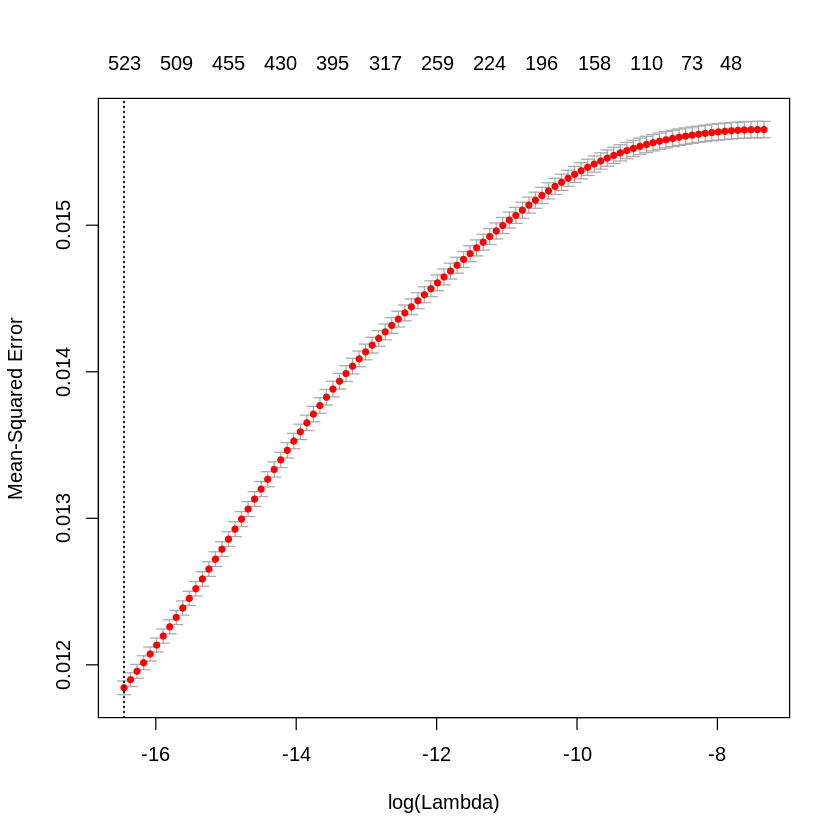

In [7]:
set.seed(0)

y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_gaussian_controls %>% as.matrix()
#head(X)

######### finding the best alpha #########
set.seed(0)
lasso_cva <- cva.glmnet(X, y, nfolds = 10)
enet_performance <- data.frame(alpha = lasso_cva$alpha)
models <- lasso_cva$modlist
enet_performance$cvm <- vapply(models, get_cvm, numeric(1))

minix <- which.min(enet_performance$cvm)
best_alpha <- lasso_cva$alpha[minix]
###########################################

######### finding the best lambda #########
set.seed(0)
lasso_cv <- cv.glmnet(X, y, alpha = best_alpha,
                      standardize = FALSE, nfolds = 10)

plot(lasso_cv)
###########################################

In [8]:
(lambda_cv <- lasso_cv$lambda.min)

[1] 7.150773e-08

## Fit the model on all controls

In [9]:
y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_gaussian_controls %>% as.matrix()

fit       <- glmnet(X, y, alpha = best_alpha, lambda = lambda_cv, standardize = FALSE)
# saving the model
saveRDS(fit, snakemake@output[["output_model"]])


## Predict on 20% normalized smoothed controls using the model (fitted on train controls) and save the predictions to the file

In [10]:
#filename = "../../../data/all_samples_normalized_gaussian_smooth_CASES.csv"
#filename = snakemake@input[["input_test_data_std"]]

test_data = readRDS(snakemake@input[["input_test"]])

In [11]:
head(test_data)

sample,bin,X30,X31,X32,X33,X34,X35,X36,X37,...,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700
PGDX16571P,chr10_400,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX16571P,chr10_40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX16571P,chr10_4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX16571P,chr10_401,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX16571P,chr10_402,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX16571P,chr10_403,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
test_data_samples_bin_rm <- test_data %>% select(-c("sample", "bin")) %>% as.matrix()
tmp <- as.vector(predict(fit, s=lambda_cv, test_data_samples_bin_rm))

In [13]:
pred_tibble <- tibble(sample = test_data$sample, bin = test_data$bin)
pred_tibble <- inner_join(pred_tibble, ATAC, by="bin")
pred_tibble <- pred_tibble %>% mutate(ATAC_predicted = tmp)

Warning message:
“Column `bin` joining factor and character vector, coercing into character vector”

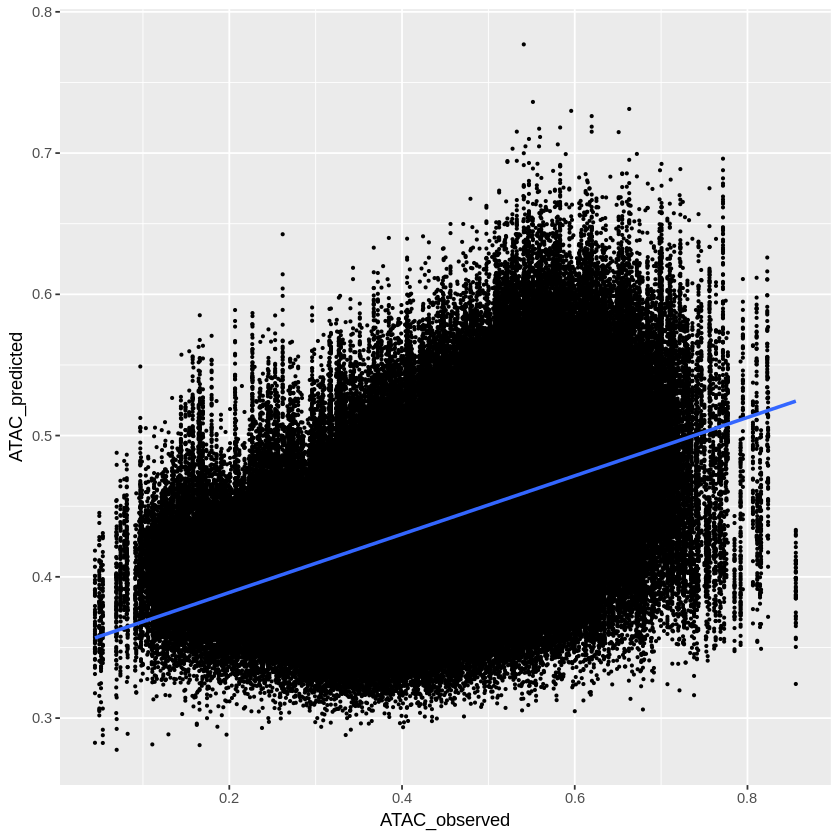

In [14]:
ggplot(pred_tibble, aes(x = ATAC_observed, y = ATAC_predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

In [15]:
cor(pred_tibble$ATAC_observed, pred_tibble$ATAC_predicted)

[1] 0.4924649

In [16]:
ae    <- abs(pred_tibble$ATAC_observed - pred_tibble$ATAC_predicted)
(mae   <- mean(ae))

[1] 0.08558206

In [17]:
se    <- (pred_tibble$ATAC_observed - pred_tibble$ATAC_predicted)^2
mse   <- mean(se)
(rmse <- sqrt(mse))

[1] 0.1093784

In [18]:
saveRDS(pred_tibble, file = snakemake@output[["output_pred"]])